In [1]:
import numpy as np
import torch 
from torch import nn
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.autograd import grad
import os
from scipy import integrate
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
# plt.rc('savefig', dpi=300)

import numpy as np
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

In [2]:
! echo $CUDA_VISIBLE_DEVICES

0,1


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
T = 1 # time [0, T]
N = 1000 # 100 # split [0, T] into N parts
h = 1e-2 # 1 #1e-2
m = 1 # in case we'd like to use other units
sig2 = np.sqrt(0.1)
mu = 0
d = 3 # points from R^d

In [5]:
time_splits = torch.Tensor(np.linspace(0, T, N+1)) 

In [6]:
class NN(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hid_dim) 
        self.relu1 = nn.Tanh()
        self.relu2 = nn.Tanh()
        self.fc2 = nn.Linear(hid_dim, hid_dim)  
        self.fc4 = nn.Linear(hid_dim, output_dim) 

    def forward(self, x, t):
        out = torch.hstack((x, t))
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc4(out)
        return out

In [7]:
def V_x_i(x): # should be grad of V
    return (x - 0.1*torch.ones(x.shape).to(device))

def v_0(x):
    return (h) / m * torch.zeros(x.shape).to(device)

def u_0(x):
    return -h * x / (2 * m * (sig2**2))


In [8]:
def get_jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.

    This is according to the reverse mode autodiff rule,

    sum_i v^b_i dy^b_i / dx^b_j = sum_i x^b_j R_ji v^b_i,

    where:
    - b is the batch index from 0 to B - 1
    - i, j are the vector indices from 0 to N-1
    - v^b_i is a "test vector", which is set to 1 column-wise to obtain the correct
        column vectors out ot the above expression.

    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """

    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(y.shape[-1]):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = grad(y,
                       x,
                       grad_outputs=v,
                       retain_graph=True,
                       create_graph=True,
                       allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)

    jacobian = torch.stack(jacobian, dim=2).requires_grad_()

    return jacobian

## Train NNs

In [9]:
dim_inp = d + 1
dim_out = d
dim_hid = 400 
net_u = NN(dim_inp, dim_hid, dim_out).to(device);
net_v = NN(dim_inp, dim_hid, dim_out).to(device);

criterion = nn.MSELoss()
learning_rate = 1e-4#0.001 #1e-6 #0.01

optimizer = torch.optim.Adam([*net_u.parameters(), *net_v.parameters()], lr=learning_rate, 
                           weight_decay=0) 

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
alpha = 0.8 #100 Score
beta = 1 #1 # 0.8 Newton
gamma = 1 # 0.8 initial

In [10]:
# 5-7k for 3d, 4k for 1d
n_iter = 7000 #7000 
iter_threshhold = 400 
batch_size = 100
loss_ref = np.inf
lines = [None, None, None]
losses = []
losses_newton = []
losses_sm = []
losses_init = []
N_fast = N

start = time.time()
with tqdm(range(n_iter), unit="iter") as tepoch:
    for tau in tepoch:
        if tau == 0: 
            l_sm = 0
            l_nl = 0
            X_0 = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, 
                                                             (sig2**2)*np.eye(d), batch_size)).to(device)
            X_0.requires_grad = True
            u0_val = torch.Tensor(u_0(X_0)).to(device)
            v0_val = torch.Tensor(v_0(X_0)).to(device)
            optimizer.zero_grad()
            eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), batch_size) for i in range(N+1)]
            for i in range(1, N_fast+1): # iterate over time steps
                t_prev = time_splits[i-1].clone()
                if i == 1:
                    X_prev = X_0.clone().to(device) # X_{i-1}
                else:
                    X_prev = X_i.clone().to(device) # X_{i-1}

                t_i = time_splits[i].clone()
                
                t_prev_batch = time_transform(t_prev).expand(batch_size, 1).to(device).clone()
                X_i = torch.Tensor(X_prev).to(device) + T / N * (net_u(X_prev, t_prev_batch) + \
                                                                 net_v(X_prev, t_prev_batch)) \
                        + torch.Tensor(np.sqrt(h*T/(m*N)) * eps[i-1]).to(device)
 
                if i > 1: 
                    Xs = torch.hstack((Xs, X_i))
                else:
                    Xs = X_i.clone()
   
            X_0_iter0 = X_0.clone() # collect X_0 from the initial iter
            Xs = torch.concat((X_0_iter0, Xs), axis=1)
        elif tau > iter_threshhold: 
            BATCH_size = int(0.2* batch_size) #int(0.5* batch_size) 10
            
            X_0_iter = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, 
                                                             (sig2**2)*np.eye(d), BATCH_size)).to(device)
            X_0_iter.requires_grad = True
            u0_val = torch.Tensor(u_0(X_0_iter)).to(device)
            v0_val = torch.Tensor(v_0(X_0_iter)).to(device)
            optimizer.zero_grad()
            eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), BATCH_size) for i in range(N+1)]
            # get one trajectory
            for i in range(1, N_fast+1): 
                t_prev = time_splits[i-1].clone()
                if i == 1:
                    X_prev = X_0_iter.clone().to(device) 
                else:
                    X_prev = X_i_iter.clone().to(device) 

                t_i = time_splits[i].clone()
                
                t_prev_batch = time_transform(t_prev).expand(BATCH_size, 1).to(device)
                X_i_iter = torch.Tensor(X_prev).to(device) + T / N * (net_u(X_prev, t_prev_batch) + \
                                                                 net_v(X_prev, t_prev_batch)) \
                        + torch.Tensor(np.sqrt(h*T/(m*N)) * eps[i-1]).to(device)
 
                if i > 1: 
                    Xs_iter = torch.hstack((Xs_iter, X_i_iter))
                else:
                    Xs_iter = X_i_iter.clone()
            Xs_iter = torch.concat((X_0_iter, Xs_iter), axis=1)
            
            # replace the old batch with the new one
            Xs_all = Xs_all.reshape((batch_size, (N+1)*d))
            X_0_all = X_0_all.reshape((batch_size, d))
            Xs_all = torch.roll(Xs_all, -BATCH_size, 0)
            X_0_all = torch.roll(X_0_all, -BATCH_size, 0)
            Xs_all = torch.vstack((Xs_all[BATCH_size:].detach(), Xs_iter.detach()) )
            Xs_all.requires_grad = True

            X_0_all = torch.vstack((X_0_all[BATCH_size:].detach(), X_0_iter.detach()) )
            X_0_all.requires_grad = True 
            
            Xs_all = Xs_all.reshape(batch_size*(N+1), d)
            X_0_all = X_0_all.reshape(batch_size, d)
            
            time_splits_batches = time_splits.repeat(batch_size).reshape(batch_size, N+1).reshape(batch_size*(N+1), 1).to(device)
            time_splits_batches.requires_grad = True
            
            out_u = net_u(Xs_all, time_splits_batches)
            out_v = net_v(Xs_all, time_splits_batches)
            du_dt = torch.zeros((batch_size*(N+1), d)).to(device)
            for i in range(d):
                vector = torch.zeros_like(out_u)
                vector[:, i] = 1 

                dudt = grad(out_u, time_splits_batches, grad_outputs=vector, create_graph=True)[0]
                du_dt[:, i] = dudt[:, 0]  
                
            dv_dt = torch.zeros((batch_size*(N+1), d)).to(device)
            for i in range(d):
                vector = torch.zeros_like(out_u)
                vector[:, i] = 1 

                dvdt = grad(out_v, time_splits_batches, grad_outputs=vector, create_graph=True)[0]
                dv_dt[:, i] = dvdt[:, 0]
            
            d_norm = torch.einsum("ijk,ik->ij", get_jacobian(lambda x: net_u(x, time_splits_batches), Xs_all), 
                                  net_u(Xs_all, time_splits_batches)) - \
                     torch.einsum("ijk,ik->ij", get_jacobian(lambda x: net_v(x, time_splits_batches), Xs_all), 
                                  net_v(Xs_all, time_splits_batches))
    
            dv_ddx = get_jacobian(lambda x: torch.einsum("jii", 
                                                get_jacobian(lambda x: net_v(x, time_splits_batches), x))[:, None], Xs_all)[:, :, 0]
#             du_ddx = torch.zeros_like(dv_ddx)
#             for j in range(d):
#                 du_ddx[:, j] = torch.einsum("jii", get_jacobian(lambda x: 
#                                             get_jacobian(lambda x: net_u(x, time_splits_batches)[:, j][:, None], x)[:, :, 0], Xs_all))
            
            du_ddx = get_jacobian(lambda x: torch.einsum("jii", 
                                                get_jacobian(lambda x: net_u(x, time_splits_batches), x))[:, None], 
                                  Xs_all)[:, :, 0]
            out_uv = net_v(Xs_all, time_splits_batches) * net_u(Xs_all, time_splits_batches)
            dvu_dx = grad(out_uv, Xs_all, grad_outputs=torch.ones_like(out_uv), create_graph=True)[0]
            L_sm = criterion(du_dt, -(h/(2*m)) * dv_ddx - dvu_dx) #/ N

            L_nl = criterion(dv_dt, d_norm + (h / 2 / m) * du_ddx \
                               -V_x_i(Xs_all).to(device)/m) #/ N 
            
            u0_val = torch.Tensor(u_0(X_0_all)).to(device)
            v0_val = torch.Tensor(v_0(X_0_all)).to(device)
            L_ic = criterion(net_u(X_0_all, 
                                   time_splits[0].expand(batch_size, 1).to(device)), u0_val) \
                     + criterion(net_v(X_0_all, 
                                       time_splits[0].expand(batch_size, 1).to(device)), v0_val)
            
            loss = (alpha * L_sm + beta * L_nl + gamma * L_ic) / 3.0
            losses.append(loss.item())
            losses_newton.append(L_nl.item())
            losses_sm.append(L_sm.item())
            losses_init.append(L_ic.item())
            tepoch.set_postfix(loss_iter=loss.item(), loss_mean=np.mean(losses[-10:]), loss_std=np.std(losses[-10:]))

            loss.backward()
            optimizer.step()
            
        elif tau <= iter_threshhold:
            BATCH_size = int(0.6* batch_size)

            X_0_iter = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, 
                                                             (sig2**2)*np.eye(d), BATCH_size)).to(device)
            X_0_iter.requires_grad = True
            u0_val = torch.Tensor(u_0(X_0_iter)).to(device)
            v0_val = torch.Tensor(v_0(X_0_iter)).to(device)
            optimizer.zero_grad()
            eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), BATCH_size) for i in range(N+1)]
            # get one trajectory
            for i in range(1, N_fast+1): 
                t_prev = time_splits[i-1].clone()
                if i == 1:
                    X_prev = X_0_iter.clone().to(device) 
                else:
                    X_prev = X_i_iter.clone().to(device) 

                t_i = time_splits[i].clone()

                t_prev_batch = time_transform(t_prev).expand(BATCH_size, 1).to(device)
                X_i_iter = torch.Tensor(X_prev).to(device) + T / N * (net_u(X_prev, t_prev_batch) + \
                                                                 net_v(X_prev, t_prev_batch)) \
                        + torch.Tensor(np.sqrt(h*T/(m*N)) * eps[i-1]).to(device)

                if i > 1: 
                    Xs_iter = torch.hstack((Xs_iter, X_i_iter))
                else:
                    Xs_iter = X_i_iter.clone()
                    
            Xs_iter = torch.concat((X_0_iter, Xs_iter), axis=1)
            
            # replace the old batch with the new one
            if tau == 1:
                Xs_all = torch.vstack((Xs[BATCH_size:].detach(), Xs_iter.detach()) )
                Xs_all.requires_grad = True

                X_0_all = torch.vstack((X_0_iter0[BATCH_size:].detach(), X_0_iter.detach()) )
                X_0_all.requires_grad = True
            else:
                Xs_all = Xs_all.reshape((batch_size, (N+1)*d))
                X_0_all = X_0_all.reshape((batch_size, d))
                Xs_all = torch.roll(Xs_all, -BATCH_size, 0)
                X_0_all = torch.roll(X_0_all, -BATCH_size, 0)
                Xs_all = torch.vstack((Xs_all[BATCH_size:].detach(), Xs_iter.detach()) )
                Xs_all.requires_grad = True

                X_0_all = torch.vstack((X_0_all[BATCH_size:].detach(), X_0_iter.detach()) )
                X_0_all.requires_grad = True

            Xs_all = Xs_all.reshape(batch_size*(N+1), d)
            X_0_all = X_0_all.reshape(batch_size, d)

            time_splits_batches = time_splits.repeat(batch_size).reshape(batch_size, N+1).reshape(batch_size*(N+1), 1).to(device)
            time_splits_batches.requires_grad = True

            out_u = net_u(Xs_all, time_splits_batches)
            out_v = net_v(Xs_all, time_splits_batches)
            du_dt = torch.zeros((batch_size*(N+1), d)).to(device)
            for i in range(d):
                vector = torch.zeros_like(out_u)
                vector[:, i] = 1 

                dudt = grad(out_u, time_splits_batches, grad_outputs=vector, create_graph=True)[0]
                du_dt[:, i] = dudt[:, 0]  
                
            dv_dt = torch.zeros((batch_size*(N+1), d)).to(device)
            for i in range(d):
                vector = torch.zeros_like(out_u)
                vector[:, i] = 1 

                dvdt = grad(out_v, time_splits_batches, grad_outputs=vector, create_graph=True)[0]
                dv_dt[:, i] = dvdt[:, 0]
                
            d_norm = torch.einsum("ijk,ik->ij", get_jacobian(lambda x: net_u(x, time_splits_batches), Xs_all), 
                                  net_u(Xs_all, time_splits_batches)) - \
                     torch.einsum("ijk,ik->ij", get_jacobian(lambda x: net_v(x, time_splits_batches), Xs_all), 
                                  net_v(Xs_all, time_splits_batches))
    
            dv_ddx = get_jacobian(lambda x: torch.einsum("jii", 
                                                get_jacobian(lambda x: net_v(x, time_splits_batches), x))[:, None], 
                                  Xs_all)[:, :, 0]
        
#             du_ddx = torch.zeros_like(dv_ddx)
#             for j in range(d):
#                 du_ddx[:, j] = torch.einsum("jii", get_jacobian(lambda x: 
#                                             get_jacobian(lambda x: net_u(x, time_splits_batches)[:, j][:, None], 
#                                                          x)[:, :, 0], Xs_all))
            
            du_ddx = get_jacobian(lambda x: torch.einsum("jii", 
                                                get_jacobian(lambda x: net_u(x, time_splits_batches), x))[:, None], 
                                  Xs_all)[:, :, 0]
        
            out_uv = net_v(Xs_all, time_splits_batches) * net_u(Xs_all, time_splits_batches)
            dvu_dx = grad(out_uv, Xs_all, grad_outputs=torch.ones_like(out_uv), create_graph=True)[0]
            
            L_sm = criterion(du_dt, -(h/(2*m)) * dv_ddx - dvu_dx) #/N

            L_nl = criterion(dv_dt, d_norm + (h / 2 / m) * du_ddx - V_x_i(Xs_all).to(device)/m) #/N

            u0_val = torch.Tensor(u_0(X_0_all)).to(device)
            v0_val = torch.Tensor(v_0(X_0_all)).to(device)
            L_ic = criterion(net_u(X_0_all, 
                                   time_splits[0].expand(batch_size, 1).to(device)), u0_val) \
                     + criterion(net_v(X_0_all, 
                                       time_splits[0].expand(batch_size, 1).to(device)), v0_val)

            loss = (alpha * L_sm + beta * L_nl + gamma * L_ic) / 3.0
            losses.append(loss.item())
            losses_newton.append(L_nl.item())
            losses_sm.append(L_sm.item())
            losses_init.append(L_ic.item())
            tepoch.set_postfix(loss_iter=loss.item(), loss_mean=np.mean(losses[-10:]), loss_std=np.std(losses[-10:]))
            
            loss.backward(retain_graph=True)
            optimizer.step()
        else:
            print('NO CHOICE')


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [3:01:13<00:00,  1.09s/iter, loss_iter=1.75e-5, loss_mean=1.55e-5, loss_std=1.11e-6]


In [ ]:
# torch.save(net_u.to('cpu'), 'net_u.pth')
# torch.save(net_v.to('cpu'), 'net_v.pth')
# net_u.to(device), net_v.to(device);

In [10]:
# net_u = torch.load('net_u_osc_3d_7k_eз.pth')
# net_v = torch.load('net_u_osc_3d_7k_eз.pth')
net_u = torch.load('net_u_osc_3d_7k_ep_fixX0iter.pth')
net_v = torch.load('net_v_osc_3d_7k_ep_fixX0iter.pth')
net_u.to(device), net_v.to(device);

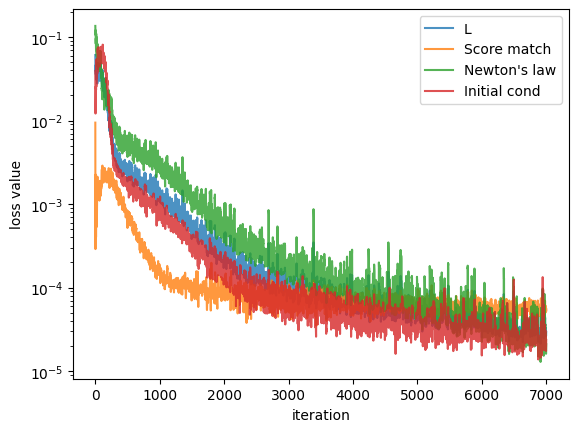

In [11]:
plt.plot(losses, alpha=0.8, label='L')
plt.plot(losses_sm, alpha=0.8,  label='Score match')
plt.plot(losses_newton, alpha=0.8,  label='Newton\'s law')
plt.plot(losses_init, alpha=0.8,  label='Initial cond')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.yscale('log')
plt.legend();

In [11]:
def plot_stats(x, m, v, t, sol_m, sol_v):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(8, 3)
    x = time_splits.numpy()

    axs[0].plot(x, m.mean(axis=0), color='green', label='preds', linewidth=0.8)
    axs[0].plot(x, m.mean(axis=0) - m.std(axis=0), linestyle='--', color='seagreen', linewidth=0.8)
    axs[0].plot(x, m.mean(axis=0) + m.std(axis=0), linestyle='--', color='seagreen', linewidth=0.8)
    axs[0].fill_between(x, m.mean(axis=0) - m.std(axis=0), 
                        m.mean(axis=0) + m.std(axis=0), color='seagreen', 
                        alpha=0.5, linewidth=0.8)
    axs[0].plot(t, sol_m, color='black', linestyle='--', label='truth', linewidth=0.8)
    axs[0].set_xlabel('time')
    axs[0].legend();
    axs[0].set_title('Harmonic oscillator 1D mean')

    axs[1].plot(x, v.mean(axis=0), color='dodgerblue', label='preds', linewidth=0.8)
    axs[1].plot(x, v.mean(axis=0) - v.std(axis=0), linestyle='--', color='dodgerblue', linewidth=0.8)
    axs[1].plot(x, v.mean(axis=0) + v.std(axis=0), linestyle='--', color='dodgerblue', linewidth=0.8)
    axs[1].fill_between(x, v.mean(axis=0) - v.std(axis=0), 
                        v.mean(axis=0) + v.std(axis=0), color='dodgerblue', 
                        alpha=0.5, linewidth=0.8)
    axs[1].plot(t, sol_v, color='black', linestyle='--', label='truth', linewidth=0.8)
    axs[1].set_title('Harmonic oscillator 1D variance') 
    axs[1].set_xlabel('time')
    axs[1].legend();

### Define numerical solution

In [12]:

dx    = np.sqrt(1 / 20000) # np.sqrt(T / 1000)    100000                    # spatial separation
x     = np.arange(-2, 2, dx)       # spatial grid points

kx    = 0                        # mass
sigma = sig2                      # width of initial gaussian wave-packet
x0    = 0.0                     # center of initial gaussian wave-packet

A = 1.0 / (sigma * np.sqrt(2*np.pi)) # normalization constant

# Initial Wavefunction
psi0 = np.sqrt(A) * np.exp(-(x-x0)**2 / (4.0 * (sigma**2))) * np.exp(1j * 0.0 * x )


# Potential V(x)
x_Vmin = 0.1         # center of V(x)

omega = 1
k = 1
V = 0.5 * (x - x_Vmin)**2

# Laplace Operator (Finite Difference)
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2
# RHS of Schrodinger Equation
hbar = h
# hbar = 1.0545718176461565e-34
def psi_t(t, psi):
    return -1j * (-0.5 * h  / m * D2.dot(psi) + V / hbar * psi)

dt = T / 1000 # T / 10000 #T / 1000  # time interval for snapshots
t0 = 0.0    # initial time
tf = T    # final time
t_eval = time_splits#np.arange(t0, tf, dt) # np.linspace(t0, tf, len(x)**2) # np.arange(t0, tf, dt)  # recorded time shots

# Solve the Initial Value Problem
sol = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23")
bmeans = []
bstds = []
ts = []
for i, t in enumerate(sol.t):
    ts.append(t)
    bmeans.append(np.dot(x, dx * np.abs(sol.y[:,i])**2)) 
    
    bstds.append(np.dot((x - bmeans[-1]) ** 2, dx * np.abs(sol.y[:,i])**2))

In [13]:
dens_num = np.abs(sol.y.T)**2

### Sample with NN

In [21]:
net_u.eval();
net_v.eval();

samples = 10000
N = 1000
num_trials = 10
X_test = np.zeros((num_trials, N+1, samples, d))

# can change nu value for sampling
# nu = 0 no u and noise during sampling (but still running net_u(x))
nu_s = 1

for trial in range(num_trials):
    with torch.no_grad():
        X_0 = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, (sig2**2)*np.eye(d), samples)).to(device)
        X_test[trial, 0, :] = X_0.cpu().numpy()
        X_prev = X_0.clone()
        eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), samples) for i in range(N)]    
        for i in range(1, N+1):
            a = torch.hstack((X_prev, time_splits[i-1].expand(samples, 1).to(device)))
            X_i = torch.Tensor(X_prev).to(device) + T / N * \
            (nu_s * net_u(X_prev, time_splits[i-1].expand(samples, 1).to(device)) \
             + net_v(X_prev, time_splits[i-1].expand(samples, 1).to(device))) \
                       + torch.Tensor(np.sqrt((h*T * nu_s)/(m*N)) * eps[i-1]).to(device)
            X_test[trial, i, :] = X_i.cpu().numpy()
            X_prev = X_i.clone()

In [22]:
mean_trials = np.zeros((num_trials, N + 1, d))
var_trials = np.zeros((num_trials, N + 1, d))

for trial in range(num_trials):
    mean_trials[trial] = X_test[trial].mean(axis=1)
    var_trials[trial] = X_test[trial].var(axis=1)

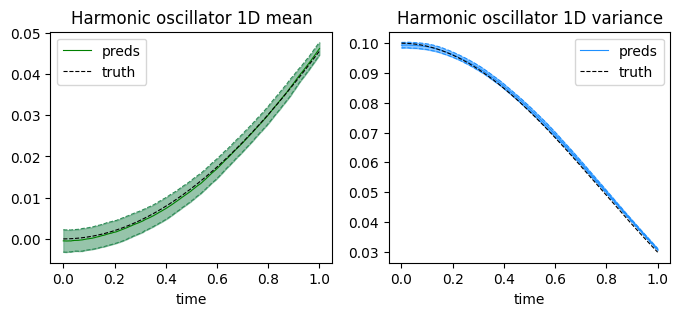

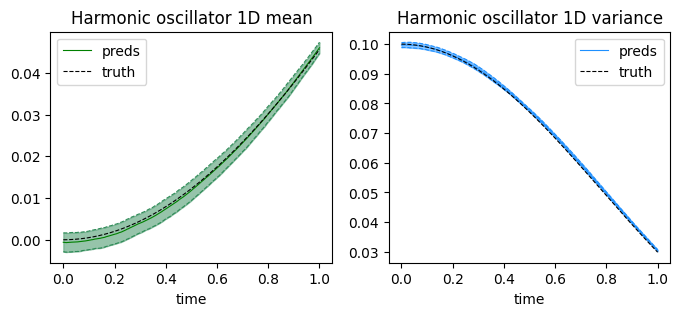

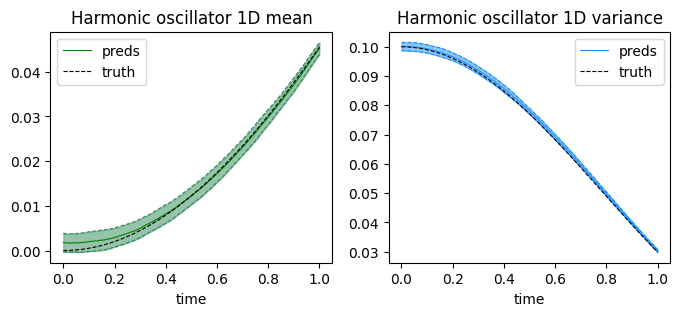

In [23]:
plot_stats(time_splits, mean_trials[:, :, 0], var_trials[:, :, 0], time_splits, bmeans, bstds)
plot_stats(time_splits, mean_trials[:, :, 1], var_trials[:, :, 1], time_splits, bmeans, bstds)
plot_stats(time_splits, mean_trials[:, :, 2], var_trials[:, :, 2], time_splits, bmeans, bstds)

In [24]:
for i in range(d): 
    err_mean_xt = (np.linalg.norm(mean_trials[:, :, i] - np.array(bmeans), axis=1) / (np.linalg.norm(bmeans))).mean()
    err_mean_xt_std = (np.linalg.norm(mean_trials[:, :, i] - bmeans, axis=1) / (np.linalg.norm(bmeans))).std()

    err_std_xt = (np.linalg.norm(var_trials[:, :, i] - bstds, axis=1) / (np.linalg.norm(bstds))).mean()
    err_std_std = (np.linalg.norm(var_trials[:, :, i] - bstds, axis=1) / (np.linalg.norm(bstds))).std()
    print(i)
    print('1D Err(mean(X_t)_NN, mean(X_t)_num): ', err_mean_xt, err_mean_xt_std)
    print('1D Err(var(X_t)_NN, var(X_t)_num): ', err_std_xt, err_std_std)

0
1D Err(mean(X_t)_NN, mean(X_t)_num):  0.09227070606139955 0.07166169223574445
1D Err(var(X_t)_NN, var(X_t)_num):  0.01422708936884708 0.003861428033031265
1
1D Err(mean(X_t)_NN, mean(X_t)_num):  0.08556243796560623 0.06170909809607687
1D Err(var(X_t)_NN, var(X_t)_num):  0.010658931531407515 0.0032598996559648342
2
1D Err(mean(X_t)_NN, mean(X_t)_num):  0.08437514613883339 0.04885266145644387
1D Err(var(X_t)_NN, var(X_t)_num):  0.014265272224661868 0.009312971759399156


In [29]:
bmeans_dim = np.stack((np.array(bmeans),) *d, axis=-1)
bmeans_dim = np.stack((np.array(bmeans_dim),) * num_trials, axis=0)

bstds_dim = np.stack((np.array(bstds),) *d, axis=-1)
bstds_dim = np.stack((np.array(bstds_dim),) * num_trials, axis=0)

bmeans_dim.shape

(10, 1001, 3)

In [32]:
print('Avg mean X_t error', 
      (np.linalg.norm(mean_trials - bmeans_dim, axis=1) / np.linalg.norm(bmeans_dim, axis=1)).mean(axis=0).mean())
print('Std of mean X_t error', 
      (np.linalg.norm(mean_trials - bmeans_dim, axis=1) / np.linalg.norm(bmeans_dim, axis=1)).std(axis=0).mean())

print('dim mean X_t error', 
      (np.linalg.norm(mean_trials - bmeans_dim, axis=1) / np.linalg.norm(bmeans_dim, axis=1)).mean(axis=0))
print('dim std of X_t error', 
      (np.linalg.norm(mean_trials - bmeans_dim, axis=1) / np.linalg.norm(bmeans_dim, axis=1)).std(axis=0))

print('dim var X_t error', 
      (np.linalg.norm(var_trials - bstds_dim, axis=1) / np.linalg.norm(bstds_dim, axis=1)).mean(axis=0))
print('dim var of X_t error', 
      (np.linalg.norm(var_trials - bstds_dim, axis=1) / np.linalg.norm(bstds_dim, axis=1)).std(axis=0))

Avg mean X_t error 0.08740276338861304
Std of mean X_t error 0.06074115059608839
dim mean X_t error [0.09227071 0.08556244 0.08437515]
dim std of X_t error [0.07166169 0.0617091  0.04885266]
dim var X_t error [0.01422709 0.01065893 0.01426527]
dim var of X_t error [0.00386143 0.0032599  0.00931297]


Just across one dimension: 

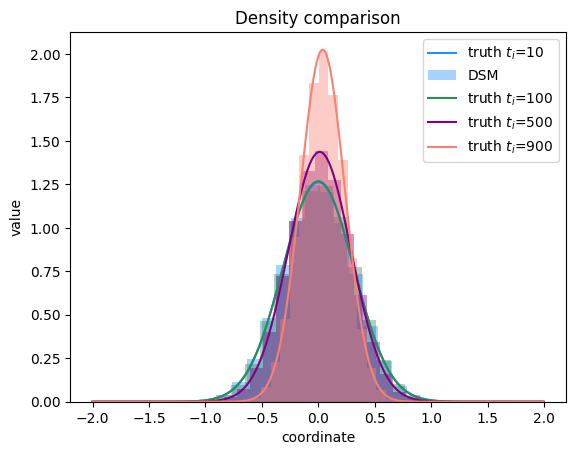

In [31]:
t_step=10
plt.plot(x, dens_num[t_step, :], color="dodgerblue", label='truth $t_i$={}'.format(t_step))
plt.hist(X_test[0:3, t_step, :, 2].reshape(-1), bins=20, color="dodgerblue", density=True, alpha=0.4, 
         label='DSM');
# plt.plot(x_pinn, dens_pinn[t_step, :],'--', color="dodgerblue", label='PINN')
t_step=100
plt.plot(x, dens_num[t_step, :], color="seagreen", label='truth $t_i$={}'.format(t_step))
plt.hist(X_test[0:3, t_step, :, 2].reshape(-1), bins=20, color="seagreen", density=True, alpha=0.4);
# plt.plot(x_pinn, dens_pinn[t_step, :],'--', color="seagreen", label='PINN')

t_step=500
plt.plot(x, dens_num[t_step, :], color="purple", label='truth $t_i$={}'.format(t_step))
plt.hist(X_test[0:3, t_step, :, 2].reshape(-1), bins=20, color="purple", density=True, alpha=0.4);
# plt.plot(x_pinn, dens_pinn[t_step, :].reshape(-1),'--', color="purple")
plt.legend();

t_step=900
plt.plot(x, dens_num[t_step, :], color="salmon", label='truth $t_i$={}'.format(t_step))
plt.hist(X_test[0:3, t_step, :, 2].reshape(-1), bins=20, color="salmon",  density=True, alpha=0.4);
# plt.plot(x_pinn, dens_pinn[t_step, :].reshape(-1),'--', color="salmon")
plt.xlabel('coordinate')
plt.ylabel('value')
plt.legend();
plt.title('Density comparison');

In [35]:
# Doman bounds
lb = np.array([-2.0, 0.0])
ub = np.array([2.0, 1])

In [43]:
n_bins = len(x)
p = np.zeros((d, len(t_eval), n_bins))
for j in range(d):
    for i in range(len(t_eval)):
        p[j, i, :] = np.histogram(X_test[:, i, :, j].reshape(-1), 
                               density=True, bins=n_bins, range=(-2, 2))[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1138735/912128128.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[1, :2])


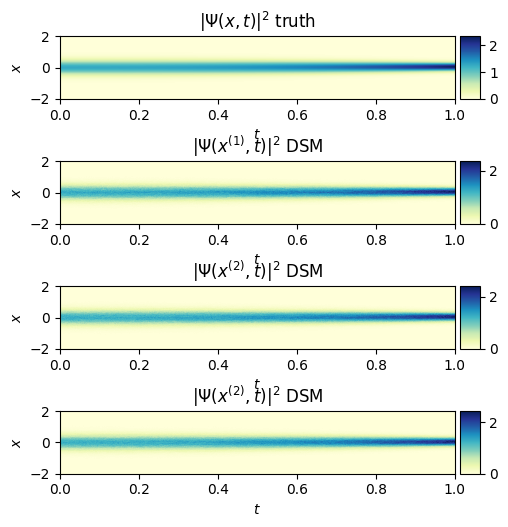

In [51]:
# dens_num
fig, ax = plt.subplots(1, 1) #newfig(1.0, 0.9)
fig.set_size_inches(6, 16)
# ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(4, 2, hspace=1)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0.1)

ax = plt.subplot(gs0[0, :2])
h_ = ax.imshow(dens_num.T, cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto', )#vmin=0., vmax=1.5)
# h_.clim(0, 1.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$|\Psi(x, t)|^2$ truth', fontsize = 12);


ax = plt.subplot(gs0[1, :2])
h_ = ax.imshow(p[0].T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')#, vmin=0., vmax=1.5)
# h_.clim(0, 2.2)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
# leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$|\Psi(x^{(1)}, t)|^2$ DSM', fontsize = 12);

ax = plt.subplot(gs0[2, :2])
h_ = ax.imshow(p[1].T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto' )#, vmin=0., vmax=1.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
# leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
# h_.clim(0, 2.2)
ax.set_title('$|\Psi(x^{(2)}, t)|^2$ DSM', fontsize = 12);

ax = plt.subplot(gs0[3, :2])
h_ = ax.imshow(p[2].T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto' )#, vmin=0., vmax=1.5)
# h_.clim(0, 1.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
# h_.clim(0, 2.2)
# leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$|\Psi(x^{(2)}, t)|^2$ DSM', fontsize = 12);

ax.set_xlabel('$t$')
ax.set_ylabel('$x$');